## 1.0a Taxi Data - Preprocessing

In this first notebook, the main dataframe is preprocessed. This includes:
- Read and display datafile
- Checking data logic & removing invalid data
- Changing its datatypes
- Dropping trivial or null columns/rows
- Splitting the data into subsets and saving them for further work

As the original data is rather large in size, it is not included in the repository. Instead, when wanting to run this notebook, it is necessary to:
1. Download the data from https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew#column-menu where you specify via Actions->Query Data->Trip Start Timestamp // In Between // 2022 Jan 01 12:00:00 AM AND 2022 Dec 31 11:59:59 PM
2. Rename the file to "taxidata"
3. Run the code cell below and add the data to the following directory

There is a short description of each column of the dataset available at: https://data.cityofchicago.org/Transportation/Taxi-Trips-2022/npd7-ywjz/about_data. In this notebook we assume that this information is known and refer to it. 

In [78]:
import os
# this directory for the original data file
os.makedirs('./data', exist_ok=True)
# this directory to later save the prepared data
os.makedirs('./data/prepped', exist_ok=True)

In [79]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Geospatial libraries
from h3 import h3 
import geopandas as gp
from shapely.geometry.polygon import Polygon

### 1.1 Read and display datafile

Data file not included in the project, needs to be downloaded individually. This step can take a few minutes due to size of the original file

In [80]:
df = pd.read_csv("data/taxidata.csv")

In [81]:
df.head(3)

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,extras,trip_total,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location
0,4404c6835b9e74e9f74d70f235200a8ce09db14a,7e179f8ef66ae99ec2d1ec89224e0b7ee5469fe5627f6d...,2022-12-31T23:45:00.000,2023-01-01T00:15:00.000,2081.0,4.42,NaN,NaN,2.0,3.0,...,0.0,20.50,Prcard,Flash Cab,42.001571,-87.695013,POINT (-87.6950125892 42.001571027),41.965812,-87.655879,POINT (-87.6558787862 41.96581197)
1,466473fd2a196ebe92fb2983cb7e8af32e39aa1f,d1d88b89ceb6d753007b6e795e3c24f4bea905a51e9d47...,2022-12-31T23:45:00.000,2023-01-01T00:00:00.000,812.0,0.00,NaN,NaN,8.0,24.0,...,0.0,16.57,Mobile,Flash Cab,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.901207,-87.676356,POINT (-87.6763559892 41.9012069941)
2,3f5cd3f78e5cab455606a31372a95d3204b2fb3f,847cf962bd6f62040673e6c24c24940aeb2d7fdaa54677...,2022-12-31T23:45:00.000,2023-01-01T00:00:00.000,600.0,0.90,NaN,NaN,8.0,8.0,...,3.0,12.00,Credit Card,Taxi Affiliation Services,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)


In [82]:
print('Nr. of rows:')
print(df.shape[0])

Nr. of rows:
6382425


In [83]:
# Data types
df.dtypes

trip_id                        object
taxi_id                        object
trip_start_timestamp           object
trip_end_timestamp             object
trip_seconds                  float64
trip_miles                    float64
pickup_census_tract           float64
dropoff_census_tract          float64
pickup_community_area         float64
dropoff_community_area        float64
fare                          float64
tips                          float64
tolls                         float64
extras                        float64
trip_total                    float64
payment_type                   object
company                        object
pickup_centroid_latitude      float64
pickup_centroid_longitude     float64
pickup_centroid_location       object
dropoff_centroid_latitude     float64
dropoff_centroid_longitude    float64
dropoff_centroid_location      object
dtype: object

### 1.2 Checking data logic & removing invalid data

In the following section we will investigate the data for its validity. The location related data will be handled separately in a later section since it requires additional effort. 

#### 1.2.1 Time related features

In [84]:
# Convert time types to check if entries are from correct range
df["trip_start_timestamp"] = pd.to_datetime(df["trip_start_timestamp"])
df["trip_end_timestamp"] = pd.to_datetime(df["trip_end_timestamp"])

# In range of 2022:
print(f"Min date: {df['trip_start_timestamp'].min()}")
print(f"Max date: {df['trip_start_timestamp'].max()}")

# Convert other 
df["trip_seconds"] =  pd.to_numeric(df['trip_seconds'])

Min date: 2022-01-01 00:00:00
Max date: 2022-12-31 23:45:00


Make sure these are the right dates, here it should say **2022-01-01 00:00:00** and **2022-12-31 23:45:00**. 

Drop trips with start_time > end_time:

In [85]:
invalid_time = df[df['trip_end_timestamp'] < df['trip_start_timestamp']].index

df = df.drop(invalid_time)

Add additional trip_hours feature for better intuitive understanding of the time compared to trip_seconds:

In [86]:
df['trip_hours'] = df['trip_seconds'] / 3600

#### 1.2.2 Duplicate entries

In [87]:
# Check duplicates 
print("Number of duplicate entries: ", df.duplicated().sum())

Number of duplicate entries:  0


If one considers all columns there seem to be no features. But since we don't exactly know how the trip_id is derived and assigned in the data collection process, we check for duplicates without considering trip_id:

In [88]:
# columns not to consider
exclude_columns = ['trip_id']

# columns to consider
columns_to_consider = list(set(df.columns) - set(exclude_columns))

In [89]:
# Check duplicates 
print("Number of duplicate entries: ", df.duplicated(subset = columns_to_consider).sum())

Number of duplicate entries:  17551


Same with additionally taxi_id:

In [90]:
# columns not to consider
exclude_columns = ['trip_id', 'taxi_id']

# columns to consider
columns_to_consider = list(set(df.columns) - set(exclude_columns))

In [91]:
# Check duplicates 
print("Number of duplicate entries: ", df.duplicated(subset = columns_to_consider).sum())

Number of duplicate entries:  20282


It is very unlikely that two or more rows that share the same value for every column except for trip_id and taxi_id are no duplicates. So we decide to drop these additional duplicate rows:

In [92]:
df = df.drop_duplicates(subset = columns_to_consider, keep='first')

In [93]:
print('There still are ' + str(df.shape[0]) + ' rows in the dataset')

There still are 6362021 rows in the dataset


#### 1.2.3 Checking and handling NAN values 

In [94]:
# Look into NAN values
print(f"General shape of dataframe: {df.shape}")
print(df.isna().sum())

General shape of dataframe: (6362021, 24)
trip_id                             0
taxi_id                           353
trip_start_timestamp                0
trip_end_timestamp                210
trip_seconds                     1333
trip_miles                         56
pickup_census_tract           3745802
dropoff_census_tract          3694176
pickup_community_area          512313
dropoff_community_area         631574
fare                             3512
tips                             3512
tolls                            3512
extras                           3512
trip_total                       3512
payment_type                        0
company                             0
pickup_centroid_latitude       510051
pickup_centroid_longitude      510051
pickup_centroid_location       510051
dropoff_centroid_latitude      595868
dropoff_centroid_longitude     595868
dropoff_centroid_location      595868
trip_hours                       1333
dtype: int64


##### taxi_id:
We drop the 353 rows with NAN values, since its only a very small amount and there is no possibility to derive the missing values:

In [95]:
df = df.drop(df[( df['taxi_id'].isna() )].index)

##### trip_end_timestamp:

In [96]:
print('Nr. of rows where trip_end_timestamp is missing:')
print(df[( df['trip_end_timestamp'].isna() )].shape[0])

print('Nr. of rows where trip_end_timestamp is missing and also trip_seconds:')
print(df[( df['trip_end_timestamp'].isna() ) & ( df['trip_seconds'].isna() )].shape[0])

Nr. of rows where trip_end_timestamp is missing:
209
Nr. of rows where trip_end_timestamp is missing and also trip_seconds:
209


For every where trip_end_timestamp is missing, also trip_seconds is missing. So we can't calculate it and will drop these rows:

In [97]:
df = df.drop(df[( df['trip_end_timestamp'].isna() )].index)

##### trip_seconds:

For the rows with missing trip_seconds we can now calculate it from trip_start_timestamp and trip_end_timestamp:

In [98]:
print('Nr. of rows where trip_seconds is missing:')
print(df[( df['trip_seconds'].isna() )].shape[0])

Nr. of rows where trip_seconds is missing:
1123


In [99]:
mask = df['trip_seconds'].isna()
df.loc[mask, 'trip_seconds'] = (df.loc[mask, 'trip_end_timestamp'] - df.loc[mask, 'trip_start_timestamp']).dt.total_seconds()

# also calculate the missing trip_hours from the new trip_seconds
df['trip_hours'] = df['trip_seconds'] / 3600

##### trip_miles:
We will drop rows with missing values, since there are only 56 of them and we don't see any possibility to derive it from the pickup and dropoff information since it does not contain information about the actual route of the trip:

In [100]:
print('Nr. of rows where trip_miles is missing:')
print(df[( df['trip_miles'].isna() )].shape[0])

Nr. of rows where trip_miles is missing:
56


In [101]:
df = df.drop(df[( df['trip_miles'].isna() )].index)

In [102]:
print(df.isna().sum())

trip_id                             0
taxi_id                             0
trip_start_timestamp                0
trip_end_timestamp                  0
trip_seconds                        0
trip_miles                          0
pickup_census_tract           3745273
dropoff_census_tract          3693575
pickup_community_area          511854
dropoff_community_area         631009
fare                             3509
tips                             3509
tolls                            3509
extras                           3509
trip_total                       3509
payment_type                        0
company                             0
pickup_centroid_latitude       509592
pickup_centroid_longitude      509592
pickup_centroid_location       509592
dropoff_centroid_latitude      595303
dropoff_centroid_longitude     595303
dropoff_centroid_location      595303
trip_hours                          0
dtype: int64


##### fare to trip_total:

In [103]:
print('Nr of rows where everything from fare to trip_total is missing: ' + str(df[( df['fare'].isna() ) & ( df['tips'].isna() ) & ( df['tolls'].isna() ) & ( df['extras'].isna() ) & ( df['trip_total'].isna() )].shape[0]))


Nr of rows where everything from fare to trip_total is missing: 3509


This matches with the number of missing values in each of the single columns. So if one component of the total trip costs is missing, every other component is also missing. Since we have no possiblity to derive these values and there are only 3.512 of more than 6.000.000 rows affected, we drop these rows:

In [104]:
df = df.drop(df[( df['trip_total'].isna() )].index)

In [105]:
print(df.isna().sum())
print(df.shape[0])

trip_id                             0
taxi_id                             0
trip_start_timestamp                0
trip_end_timestamp                  0
trip_seconds                        0
trip_miles                          0
pickup_census_tract           3743504
dropoff_census_tract          3691862
pickup_community_area          511275
dropoff_community_area         630443
fare                                0
tips                                0
tolls                               0
extras                              0
trip_total                          0
payment_type                        0
company                             0
pickup_centroid_latitude       509020
pickup_centroid_longitude      509020
pickup_centroid_location       509020
dropoff_centroid_latitude      594770
dropoff_centroid_longitude     594770
dropoff_centroid_location      594770
trip_hours                          0
dtype: int64
6357894


#### 1.2.4 trip_total logic

From the source of the dataset we know that fare, tips, tolls, and extras should add up to the amount trip_total states, whereby cash tips will generaly not be recorded. Check if this is true and if trip_total is valid:

In [106]:
df_costs = df

df_costs = df_costs[['fare', 'tips', 'tolls', 'extras', 'trip_total']].copy()

In [107]:
def check_and_calculate_deviation_of_cost_components_to_total_amount(df_costs):
    # columns to sum
    columns_to_sum = ['fare', 'tips', 'tolls', 'extras']

    # check if the sum of the specified columns equals the trip_total
    check_sum = df_costs[columns_to_sum].sum(axis=1) == df_costs['trip_total']

    # calculate the difference
    sum_diff = df_costs['trip_total'] - df_costs[columns_to_sum].sum(axis=1)

    return check_sum, sum_diff

In [108]:
check_sum, sum_diff = check_and_calculate_deviation_of_cost_components_to_total_amount(df_costs)

df_costs['check_sum'] = check_sum
df_costs['sum_diff'] = sum_diff

In [109]:
print('The trip_total deviates from the sum of the other cost related columns in ' + str(df_costs[~df_costs['check_sum']].shape[0]) + ' rows.')

The trip_total deviates from the sum of the other cost related columns in 1842878 rows.


Check how large these differences are or if they could be just be caused by cash tips not recorded in the tips column but somehow consideration in the total_trip column for example if the drivers manually record it only in the total_trip amount:

In [110]:
# only consider the rows where the sum is not matching
print(df_costs[~df_costs['check_sum']]['sum_diff'].describe())

count    1.842878e+06
mean     5.424019e-01
std      4.185221e-01
min     -1.818989e-12
25%      5.000000e-01
50%      5.000000e-01
75%      5.000000e-01
max      2.500000e+01
Name: sum_diff, dtype: float64


We can see that the deviation is not large in the mean. Also the largest deviation in to the negative is small. Only the maximum positiv deviation is a higher value. Check the distribution of the deviations by again only considering these rows, where the sum is not matching. The x-limits are derived from the stistics above:

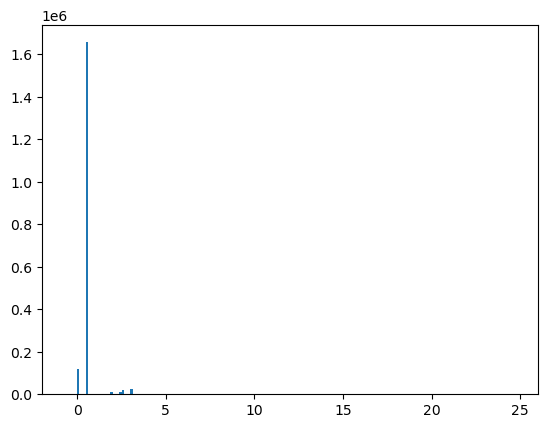

In [111]:
plt.hist(df_costs[~df_costs['check_sum']]['sum_diff'], bins=200)
plt.xlim(-2,26)
plt.show()

Here we also see that most deviations are very small and under five dollars. Now only consider larger deviations of more than five dollars:

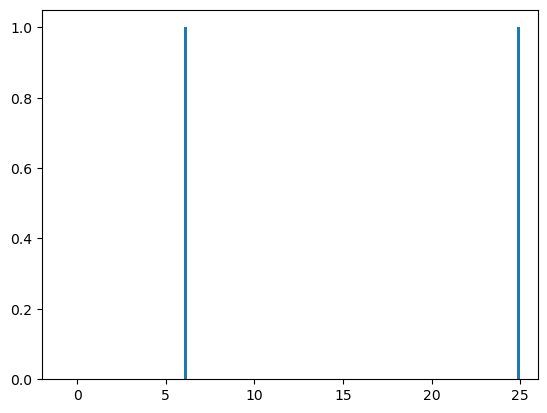

In [112]:
plt.hist(df_costs[( df_costs['sum_diff'] > 5 ) | ( df_costs['sum_diff'] < -5 )]['sum_diff'], bins=100)
plt.xlim(-2,26)
plt.show()

There are only 2 cases where the sum deviates more than five dollars. We evaluate all of these deviations as not critical, since they mostly are very small and could be the result of not separately recorded cash tips. We will also keep the rows with the larger deviations for now, since the adjustment for outliers is just about to follow in the next section.

#### 1.2.5 Drop Outliers

For numeric values we can check for outliers. This affects trip_seconds, trip_miles, fare, tips, tolls, extras and trip_total.

In [113]:
df_outliers = df

#### --- Plots of outliers here ---

In [114]:
def drop_outliers(df, column, mean, std):
    return df[(df[column] > mean - 3 * std) & (df[column] < mean + 3 * std)]

Calculate outliers on the whole current dataset, before dropping rows that are outliers in another column. 

In [115]:
std_trip_seconds = df_outliers['trip_seconds'].describe(include='all').loc['std']
mean_trip_seconds = df_outliers['trip_seconds'].describe(include='all').loc['mean']

std_trip_miles = df_outliers['trip_miles'].describe(include='all').loc['std']
mean_trip_miles = df_outliers['trip_miles'].describe(include='all').loc['mean']

std_fare = df_outliers['fare'].describe(include='all').loc['std']
mean_fare = df_outliers['fare'].describe(include='all').loc['mean']

std_tips = df_outliers['tips'].describe(include='all').loc['std']
mean_tips = df_outliers['tips'].describe(include='all').loc['mean']

std_tolls = df_outliers['tolls'].describe(include='all').loc['std']
mean_tolls = df_outliers['tolls'].describe(include='all').loc['mean']

std_extras = df_outliers['extras'].describe(include='all').loc['std']
mean_extras = df_outliers['extras'].describe(include='all').loc['mean']

std_trip_total = df_outliers['trip_total'].describe(include='all').loc['std']
mean_trip_total = df_outliers['trip_total'].describe(include='all').loc['mean']

In [116]:
print(df_outliers.shape[0])

6357894


In [117]:
df_outliers = drop_outliers(df_outliers, "trip_seconds", mean_trip_seconds, std_trip_seconds)
df_outliers = drop_outliers(df_outliers, "trip_miles", mean_trip_miles, std_trip_miles)
df_outliers = drop_outliers(df_outliers, "fare", mean_fare, std_fare)
df_outliers = drop_outliers(df_outliers, "tips", mean_tips, std_tips)
df_outliers = drop_outliers(df_outliers, "tolls", mean_tolls, std_tolls)
df_outliers = drop_outliers(df_outliers, "extras", mean_extras, std_extras)
df_outliers = drop_outliers(df_outliers, "trip_total", mean_trip_total, std_trip_total)

In [118]:
print(df_outliers.shape[0])

6256487


We dropped only about 100,000 from about 6,300,000 rows.

Now check again for the difference in the some of cost components and total_trip amount. The rows with larger deviations are removed:

In [119]:
check_sum, sum_diff = check_and_calculate_deviation_of_cost_components_to_total_amount(df_costs)

df_outliers['sum_diff'] = sum_diff

print('Nr of rows with deviations larger than five dollars: ' + str(df_outliers[(df_outliers['sum_diff'] > 5) | (df_outliers['sum_diff']  < -5)].shape[0]))

Nr of rows with deviations larger than five dollars: 0


In [120]:
# continue working on the new dataset
df_outliers = df_outliers.drop('sum_diff', axis=1)
df = df_outliers.copy()

#### 1.2.6 Check for unreasonable 0-values

In [121]:
# Number of equal zero entries after dropping
print("Number of zero entries for trip_seconds: ", len(df[df["trip_seconds"] == 0]))
print("Number of zero entries for trip_miles: ", len(df[df["trip_miles"] == 0]))
print("Number of zero entries for trip_total: ", len(df[df["trip_total"] == 0]))

Number of zero entries for trip_seconds:  145330
Number of zero entries for trip_miles:  772401
Number of zero entries for trip_total:  5480


#####  -> Cancelled Trips Logic:
We consider a trip cancelled if
- trip_miles = 0
- trip_seconds = 0
- pickup = dropoff (regarding centroid location) 

We don't consider trip_total cause there might be differing canceling charges depending on journey to the customer and potential waiting time

In [122]:
condition_geolocation = (df['pickup_centroid_location'].notna()) & (df['dropoff_centroid_location'].notna()) & (df['pickup_centroid_location'].notna() == df['dropoff_centroid_location'].notna())

condition = (condition_geolocation & ( df['trip_miles'] == 0 ) & ( df['trip_seconds'] == 0 )) 

df_cancelled = df[condition]

df_no_cancelled = df[~condition]

In [123]:
print(df_cancelled.shape)
print(df_no_cancelled.shape)

(106077, 24)
(6150410, 24)


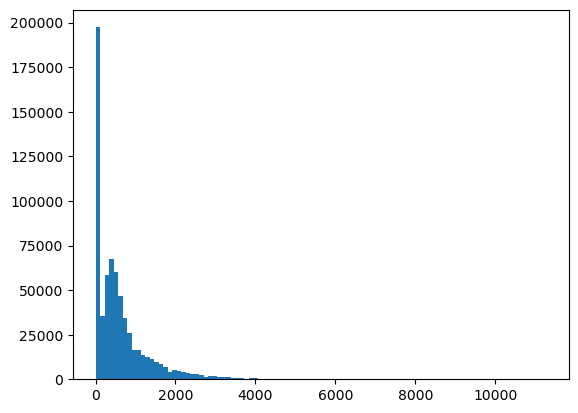

In [124]:
#title
plt.hist(df_no_cancelled[(df_no_cancelled['trip_miles'] == 0)]['trip_seconds'], bins=100)
#plt.xlim(-2,26)
plt.show()

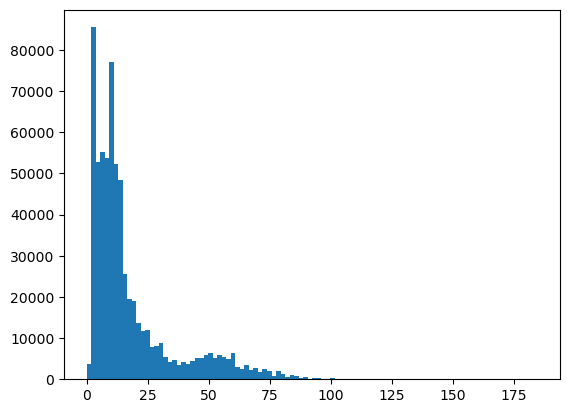

In [125]:
#title
plt.hist(df_no_cancelled[(df_no_cancelled['trip_miles'] == 0)]['trip_total'], bins=100)
#plt.xlim(-2,26)
plt.show()

In [126]:
#might be also cancelled but not sure because of missing location data
print(df_no_cancelled[(df_no_cancelled['trip_miles'] == 0) & (df_no_cancelled["trip_seconds"] == 0)].shape)

(32493, 24)


A part of the rows with zero values in the respective columns fullfills our criteria for cancelled trips, but there is also a big part where it does not because of missing location data and trip_seconds > 0. The distribution of trip_seconds and trip_total in the case of trip_miles = 0 seems non-trivial, which is why we decide to keep all of these rows for further analysis in the descriptive analytics and cluster analysis part.

#### -- plot seconds against miles here --

#### 1.2.7 Mph Logic

To have some orientation for the speed limit in Chicago/Cook County, we took this as a source: https://www.arcgis.com/home/item.html?id=5e279cbe89794bcba87809d9ae95594d which resulted in a limit of 65 mph for our taxi data, as anything above is unrealistic. Erwähne dass es nur darum geht unrealistische rows die 65 überschreitn zu entfernen. Für alles darunter hat mhp wegen Stand- und Wartezeiten nicht die große Aussagekraft

In [127]:
df['mph'] = np.where(df['trip_hours'] != 0, df['trip_miles'] / df['trip_hours'], np.nan)

In [128]:
df = df[(df["mph"] <= 65)]

In [129]:
df = df.drop('mph', axis=1)

#### 1.2.8 Prepare Different Temporal Discretization

In [130]:
df['hour'] = df['trip_start_timestamp'].dt.hour

In [131]:
print(12//4)

3


In [132]:
#0-3 - 0
#4-7 - 1
#8-11 - 2 
#12-15 - 3
#16-19 - 4
#20-23 - 5

df['4_hour_window'] = df['hour'] // 4

In [133]:
#0-5 - 0
#6-11 - 1
#12-17 - 2
#18-23 - 3

df['6_hour_window'] = df['hour'] // 6

In [134]:
df['weekday'] = df['trip_start_timestamp'].dt.day_name()

In [135]:
df['month'] = df['trip_start_timestamp'].dt.month_name()

### 1.3 Merging Community Area Data

In order to obtain the names of the pickup and dropoff community areas and the community areas itself where it is missing while having centroid_location available, we merge our dataset with a community area dataset from https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6. 

In [136]:
# Import prepped dfs
community_df = gp.read_file("data/prepped/community_df.geojson")

In [137]:
community_df.head()

,community,area_number,geometry
0,DOUGLAS,35,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ..."
1,OAKLAND,36,"MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ..."
2,FULLER PARK,37,"MULTIPOLYGON (((-87.62880 41.80189, -87.62879 ..."
3,GRAND BOULEVARD,38,"MULTIPOLYGON (((-87.60671 41.81681, -87.60670 ..."
4,KENWOOD,39,"MULTIPOLYGON (((-87.59215 41.81693, -87.59215 ..."


Merge the two datasets based on the coordinates. In our original dataset (df) we have coordinates (longitude and latitude) for each trip/row where it is available. From the Community Area dataset we have for each community area a multipolygon with coordinates that lie within this community area:

In [138]:
def merge_geodata(df, lat_col, lon_col, community_col, area_number_col, prefix):
    gdf = gp.GeoDataFrame(df, geometry=gp.points_from_xy(df[lon_col], df[lat_col]))
    gdf = gdf.rename_geometry(f"{prefix}_geometry")
    
    gdf.set_crs(epsg=4326, inplace=True)
    community_df.to_crs(epsg=4326, inplace=True)

    # Perform the spatial join
    merged_gdf = gp.sjoin(gdf, community_df, how="left", predicate="within")

    # Drop unnecessary columns
    merged_gdf = merged_gdf.drop([f"{prefix}_geometry", "index_right"], axis=1)

    # Rename columns
    merged_gdf = merged_gdf.rename(columns={
        community_col: f"{prefix}_community",
        area_number_col: f"{prefix}_area_number"
    })

    return pd.DataFrame(merged_gdf)

# Merge for pickup
df_merged = merge_geodata(df, 'pickup_centroid_latitude', 'pickup_centroid_longitude', 'community', 'area_number', 'pickup')
# Merge for dropoff
df_merged = merge_geodata(df_merged, 'dropoff_centroid_latitude', 'dropoff_centroid_longitude', 'community', 'area_number', 'dropoff')

In [139]:
df_merged.isna().sum()

trip_id                             0
taxi_id                             0
trip_start_timestamp                0
trip_end_timestamp                  0
trip_seconds                        0
trip_miles                          0
pickup_census_tract           3600489
dropoff_census_tract          3515011
pickup_community_area          473795
dropoff_community_area         541636
fare                                0
tips                                0
tolls                               0
extras                              0
trip_total                          0
payment_type                        0
company                             0
pickup_centroid_latitude       471777
pickup_centroid_longitude      471777
pickup_centroid_location       471777
dropoff_centroid_latitude      506778
dropoff_centroid_longitude     506778
dropoff_centroid_location      506778
trip_hours                          0
hour                                0
4_hour_window                       0
6_hour_windo

pickup_community and dropoff_community (from the community area dataset) represent the same values as pickup_community_area and dropoff_community_area (from the original dataset). Since we merged them based on the longitude and latitude where it is available, we dont have further opportunities to derive missing values. Thats why we drop the rows without any location data:

In [140]:
condition = (df_merged['pickup_area_number'].notna()) & (df_merged['dropoff_area_number'].notna())

df_merged = df_merged[condition]

In [141]:
df_merged.isna().sum()

trip_id                             0
taxi_id                             0
trip_start_timestamp                0
trip_end_timestamp                  0
trip_seconds                        0
trip_miles                          0
pickup_census_tract           2884556
dropoff_census_tract          2884556
pickup_community_area            1979
dropoff_community_area          29038
fare                                0
tips                                0
tolls                               0
extras                              0
trip_total                          0
payment_type                        0
company                             0
pickup_centroid_latitude            0
pickup_centroid_longitude           0
pickup_centroid_location            0
dropoff_centroid_latitude           0
dropoff_centroid_longitude          0
dropoff_centroid_location           0
trip_hours                          0
hour                                0
4_hour_window                       0
6_hour_windo

Drop the columns pickup_community_area and dropoff_community_area since we have more complete values in the pickup_community and dropoff_community columns form the merged dataset:

In [145]:
df_merged = df_merged.drop(['pickup_community_area', 'dropoff_community_area'], axis=1)

In [146]:
df_merged.isna().sum()

trip_id                             0
taxi_id                             0
trip_start_timestamp                0
trip_end_timestamp                  0
trip_seconds                        0
trip_miles                          0
pickup_census_tract           2884556
dropoff_census_tract          2884556
fare                                0
tips                                0
tolls                               0
extras                              0
trip_total                          0
payment_type                        0
company                             0
pickup_centroid_latitude            0
pickup_centroid_longitude           0
pickup_centroid_location            0
dropoff_centroid_latitude           0
dropoff_centroid_longitude          0
dropoff_centroid_location           0
trip_hours                          0
hour                                0
4_hour_window                       0
6_hour_window                       0
weekday                             0
month       

### 1.2.10 Hexagons - res8 and res7 takes too long (deswegen erstmal ausgeklammert)

In [142]:
# Get hex ids
def add_h3_ids(df, res):
    df[f"h3_res{res}_pickup"] = np.vectorize(h3.geo_to_h3)(
        df['pickup_centroid_latitude'], df['pickup_centroid_longitude'], res)
    df[f"h3_res{res}_dropoff"] = np.vectorize(h3.geo_to_h3)(
        df['dropoff_centroid_latitude'], df['dropoff_centroid_longitude'], res)
    return df

# Get poly from hex ids - vectorized form to save time
def poly_from_hex(df, colname, res):
    hex_ids = df[f"h3_res{res}_{colname}"].values
    polygons = np.vectorize(lambda hex_id: Polygon(h3.h3_to_geo_boundary(hex_id, geo_json=True)))(hex_ids)
    df[f"poly_res{res}_{colname}"] = polygons
    return df

# Get count for each trip happening in the same hexagon
def get_poly_count(df, colname):
    name = colname.split("_")[1] + "_" + colname.split("_")[2]
    df[f"count{name}"] = df.groupby(colname)['trip_id'].transform('count')
    return df

In [147]:
# For hexagon resolution, adapted: https://towardsdatascience.com/exploring-location-data-using-a-hexagon-grid-3509b68b04a2 table
df_merged = add_h3_ids(df_merged, 7)
df_merged = add_h3_ids(df_merged, 8)

#### Save Data

In [148]:
df_merged.to_csv('data/prepped/prep_taxidata.csv')